[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nunososorio/SingleCellGenomics2024/blob/main/3_Wednesday_April10th/SessionIV_p1.ipynb)


<img src="https://github.com/nunososorio/SingleCellGenomics2024/blob/main/logo.png?raw=true" alt="AnnData" style="width:600px; height:auto;"/>

## Practical Session IV - Part 1


# Hands on single-cell RNA-seq analysis

Today, we will guide you through the workflow for analyzing scRNA-seq count matrices in Python. As single cell methods are relatively new, there is not one “correct” approach to analyzing these data; however, certain steps have become accepted as a sort of standard practice. A useful overview on the current best practices is found in the article below, which we borrow from in this tutorial.

Current best practices in single-cell RNA-seq analysis: a tutorial: https://www.embopress.org/doi/full/10.15252/msb.20188746

Briefly, given a count matrix (i.e. the one contained in cellranger count output folder *filtered_bc_matrices*), the following steps are typically performed to analyze a scRNA-seq sample:
1. Quality control
2. Normalization
3. Feature selection
4. Principal component analysis
5. Dimensionality reduction (UMAP and tSNE)
6. Clustering
7. Marker gene identification
8. Cell type annotation and data visualization

As a framework for conducting these analyses, we will use the Python package scanpy, for which there is excellent documentation and even some online tutorials: https://scanpy.readthedocs.io/

Another useful resource is the following guide: https://chanzuckerberg.github.io/scRNA-python-workshop/intro/about

The objective of this session is to familiarize you with these steps and enable you to carry out your own single cell analysis! We provide you with a set of scRNA-seq datasets already processed with cellranger count and stored in a scanpy AnnData object (h5ad file):

H5AD AnnData File:
- Dataset1.h5ad https://figshare.com/ndownloader/files/34551779

This data capture single cells of the adult mouse brain from various regions and samples, from the following study: Molecular Architecture of the Mouse Nervous System (https://www.cell.com/cell/fulltext/S0092-8674(18)30789-X)

One reason for choosing this dataset is the excellent companion website: http://mousebrain.org/adolescent/

This might be particularly helpful for identifying the cell types in your data!

In  groups, please choose a unique dataset and work through the following tutorial, answering the exercises along the way in this Jupyter notebook. Your objectives are:
1. Perform preprocessing and dimensionality reduction to obtain a 2D representation of your single cells
2. Find a satisfactory clustering and set of marker genes and annotate each cell type or cell state
3. Compare your results to those obtained by the authors in their publication (mousebrain.org)

## 0. Setup the environment, load scanpy and some data

In [1]:
# Install scanpy and loompy if you don't have them already or if you are running on colab
! pip install scanpy loompy scrublet > _

In [2]:
# Load the libraries we will use
import numpy as np
import pandas as pd
import scanpy as sc
import loompy
import matplotlib.pyplot as plt
import scrublet as scr

In [3]:
# Get one of the datasets
! wget https://figshare.com/ndownloader/files/34551779 -O Dataset1.h5ad

/bin/bash: wget: command not found


In [4]:
# Adjust the output for the figures
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, facecolor='white')
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 16
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.10


In [6]:
adata = sc.read_h5ad("Dataset1.h5ad") # enter h5ad file name here

The AnnData object contains a lot of information and is essentially a fancy pandas dataframe! Some basic commands to view the object are shown below (for a fully annotated dataset).

In [7]:
adata # prints an overview of information on the AnnData object

AnnData object with n_obs × n_vars = 4291 × 27998

In [8]:
adata.X # view the count matrix (rows x columns, cells x genes)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
# Question: how do many cells do I have? how many genes do I have?

In [10]:
adata.obs.head() # view a pandas data frame containing metadata on the cells

""
10X81_1_ATTGATCAGGTTCA--10
10X55_5_GTAGGTCAACACAC--1
10X20_2_TGAGCTGATTTGGG-1-5
10X20_2_AGTTTAGAAACGGG-1-1
10X22_4_CGTGTAGATGCACA-1-7


In [11]:
adata.var.head() # view a pandas data frame containing metadata on the genes

""
Cbln2
Ptchd2
P2rx2
Ptger4
Fam19a1


You can also get information about data in the rows and columns of adata.obs and adata.var as you would for a pandas dataframe, using functions such as sum(), mean(), groupby(), and value_counts(). However, your initial dataset should contain relatively little metadata at first - You will add more information as you perform various steps of the analysis!

## 1. Quality control

In general, quality control (QC) should be done before any downstream analysis is performed. How the data is cleaned likely will have huge effects on downstream results, so it’s imperative to invest the time in choosing QC methods that you think are appropriate for your data!

Goals:
- Filter the data to only include true cells that are of high quality, so that when we cluster our data it is easier to identify distinct cell type populations.
- Identify any failed samples and either try to salvage the data or remove them from analysis, in addition to trying to understand why the sample failed.

Challenges:
- Delineating cells that are poor quality from less complex cells
- Choosing appropriate thresholds for filtering, so as to keep high quality cells without removing biologically relevant cell types or cell states.

Before analyzing the scRNA-seq gene expression data, we should ensure that all cellular barcode data corresponds to viable cells. Cell QC is commonly performed based on three QC covariates:
- Library size: the number of counts per barcode (count depth)
- Detected genes: the number of genes per barcode
- Mitochondrial reads: the fraction of counts from mitochondrial genes per barcode.

Library size: First, consider the total number of reads (UMIs) detected per cell. Cells with few reads are likely to have been broken or failed to capture a cell, and should thus be removed. Cells with many reads above the average for a sample are likely to be doublets, or two cells encapsulated in the gel bead during the protocol.

### **Exercise 1**:
Using the scanpy and matplotlib packages, visualize a histogram of the distribution of total counts per cell in the dataset. Save this information as metadata to the adata.obs dataframe using a command such as: adata.obs["n_counts"] = n_counts_array. Choose lower and upper boundaries to filter out poor-quality cells and doublets.

Histogram function: plt.hist()
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

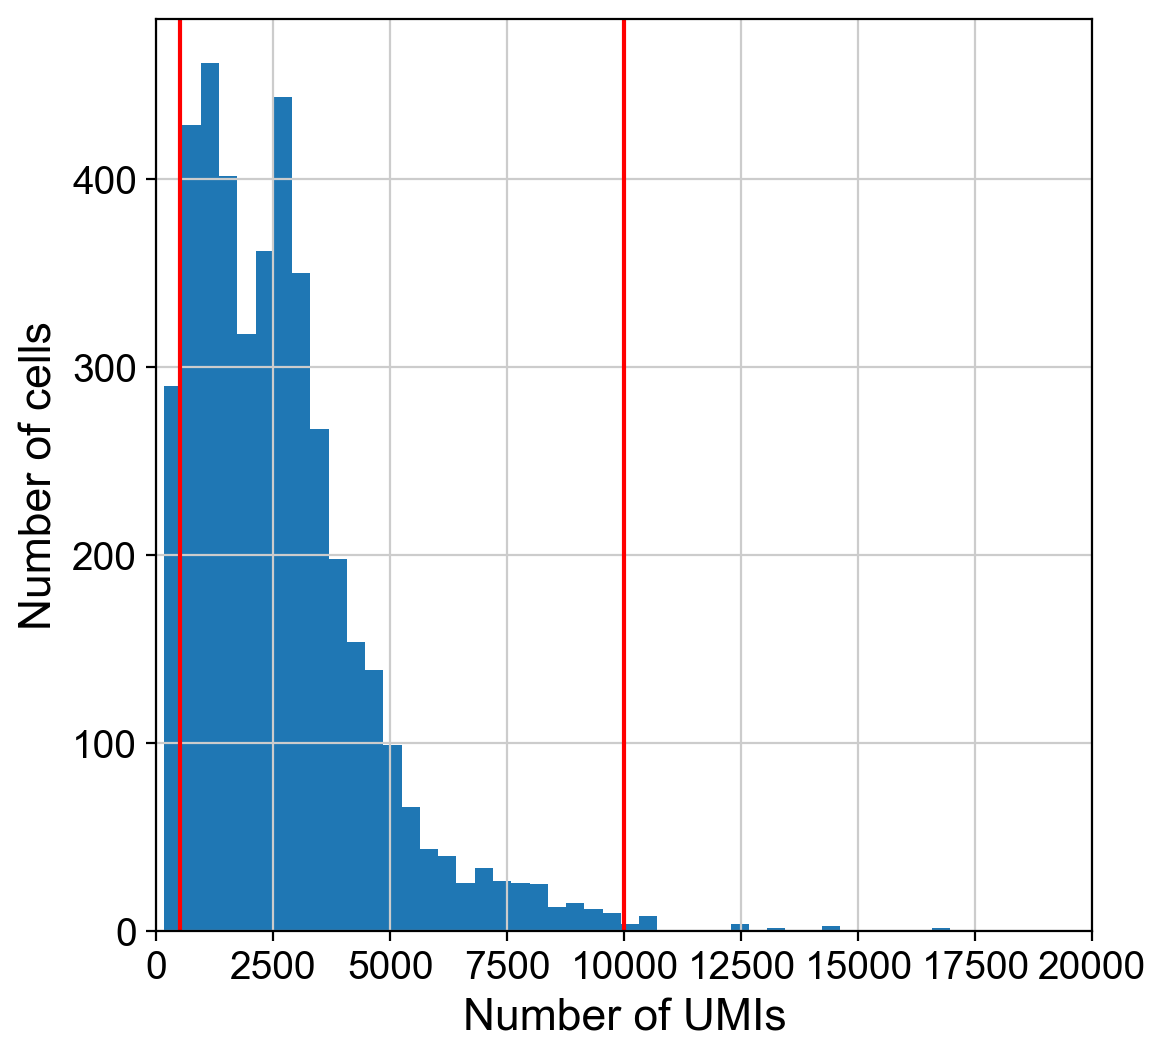

In [12]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel('Number of UMIs') # what are you plotting on the x-axis? Label it!
plt.ylabel('Number of cells') # what are you plotting on the x-axis? Label it!
plt.axvline(500, c="r") # specify the lower cutoff value for total UMIs
plt.axvline(10000, c="r") # specify the upper cutoff value for total UMIs
plt.xlim(0, 20000)
plt.show()

### **Exercise 2**:
Using the scanpy and matplotlib packages, visualize a histogram of the distribution of total genes expressed per cell in the dataset. Save this information as metadata to the adata.obs dataframe using a command such as: adata.obs["n_genes"] = n_genes_array. Choose lower and upper boundaries to filter out low-diversity cells.

normalizing counts per cell
    finished (0:00:00)


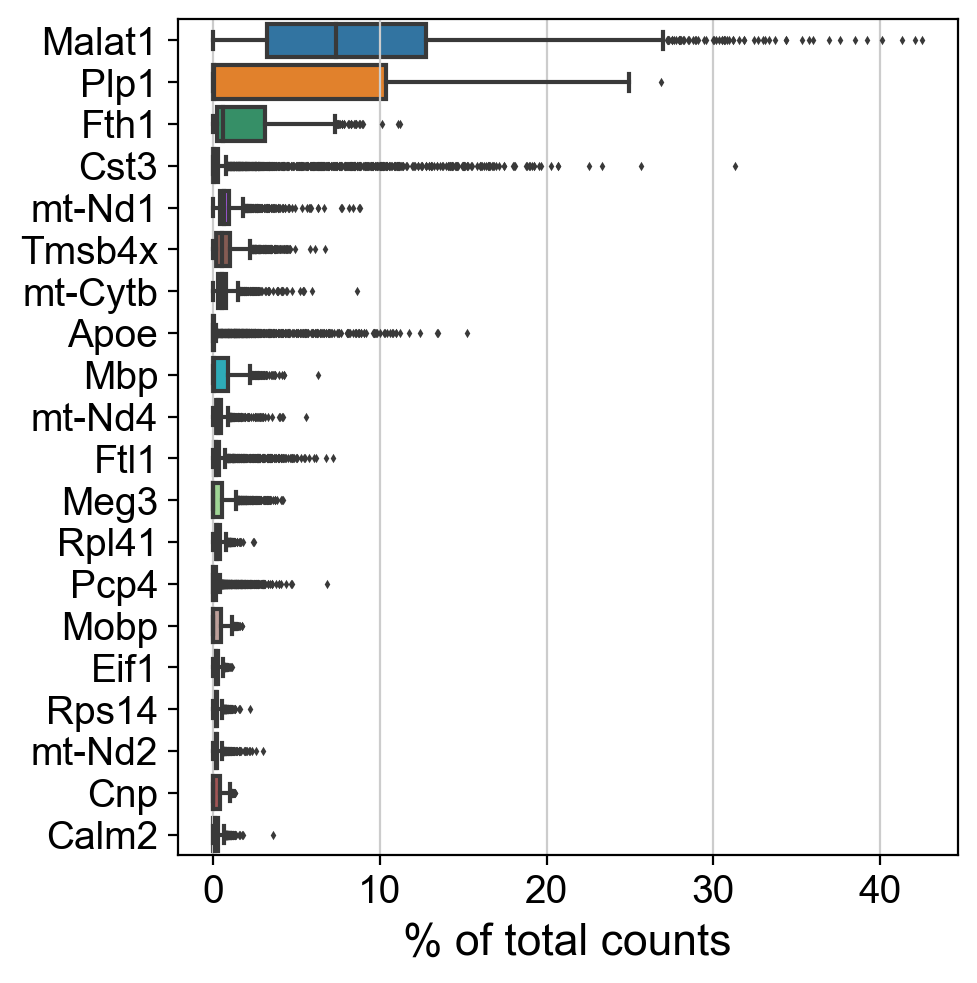

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20)

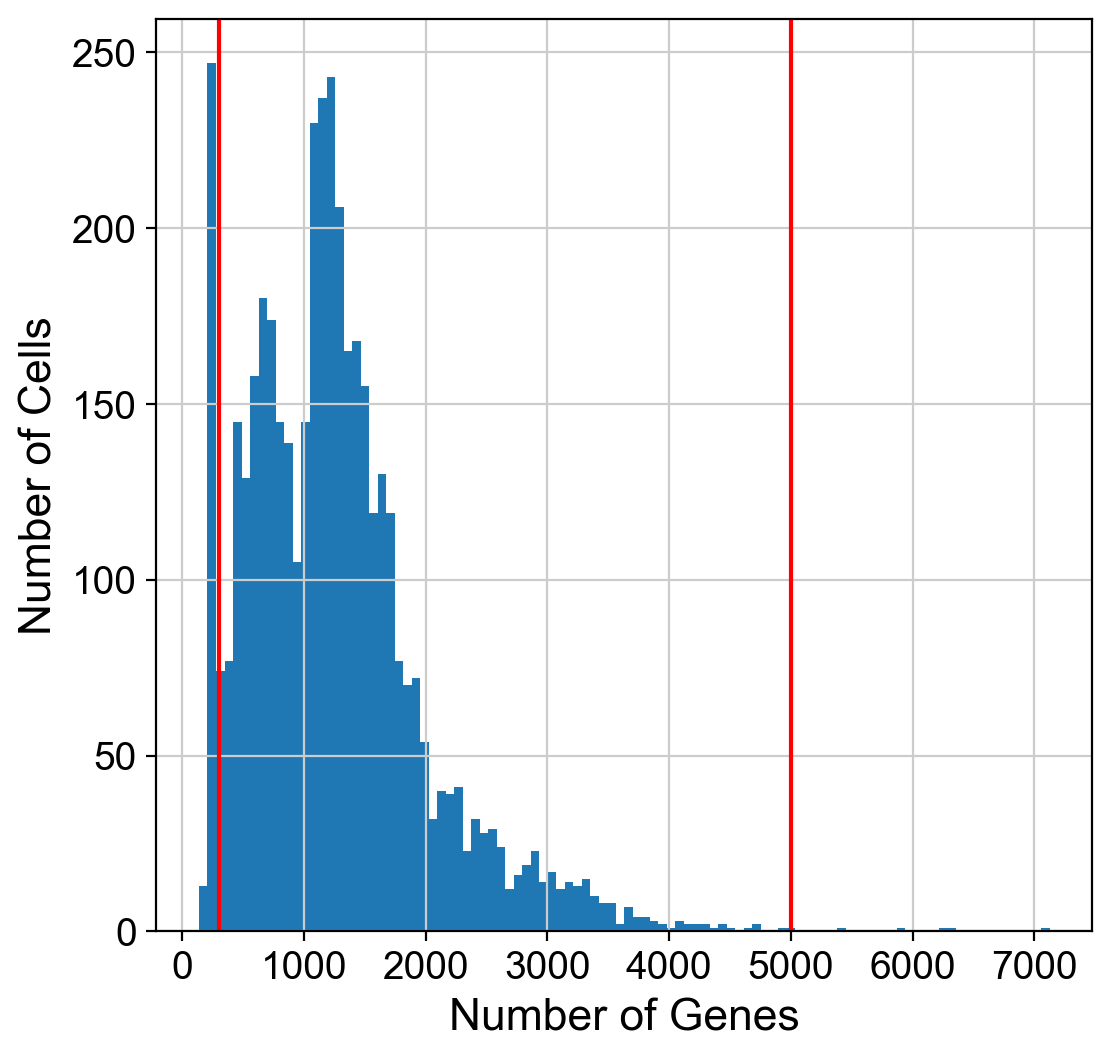

In [14]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(300, c="r") # specify the lower cutoff for number of detected genes
plt.axvline(5000, c="r") # specify the upper cutoff for number of detected genes
plt.xlabel('Number of Genes') # what are you plotting on the x-axis? Label it!
plt.ylabel('Number of Cells') # what are you plotting on the x-axis? Label it!
plt.show()

### **Exercise 3**:
Using the scanpy, compute the fraction of reads on each cell corresponding to mitochondrial genes.
Mitochondrial genes can be identified by their name: they all begin with 'mt-'.
You will need to **divide** the **sum of counts of mitochondrial genes** by the **sum of counts of all genes**.
Save this information as metadata to the adata.obs dataframe using a command such as: adata.obs["percent_mito"] = percent_mito_array.

In [28]:
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].copy().X, axis=1) / np.sum(adata.X, axis=1)
print(adata[:, mito_genes].var_names) # list all mitochondrial genes

Index(['mt-Co3', 'mt-Nd3', 'mt-Co2', 'mt-Atp6', 'mt-Nd4l', 'mt-Atp8', 'mt-Co1',
       'mt-Nd1', 'mt-Nd6', 'mt-Cytb', 'mt-Nd5', 'mt-Nd4', 'mt-Nd2'],
      dtype='object')


### **Exercise 4**:
Using scanpy and pyplot, visualize the three QC metrics to choose boundary values to filter out poor quality cells.

Plot the distribution of each of the metrics, and then visualize them together.

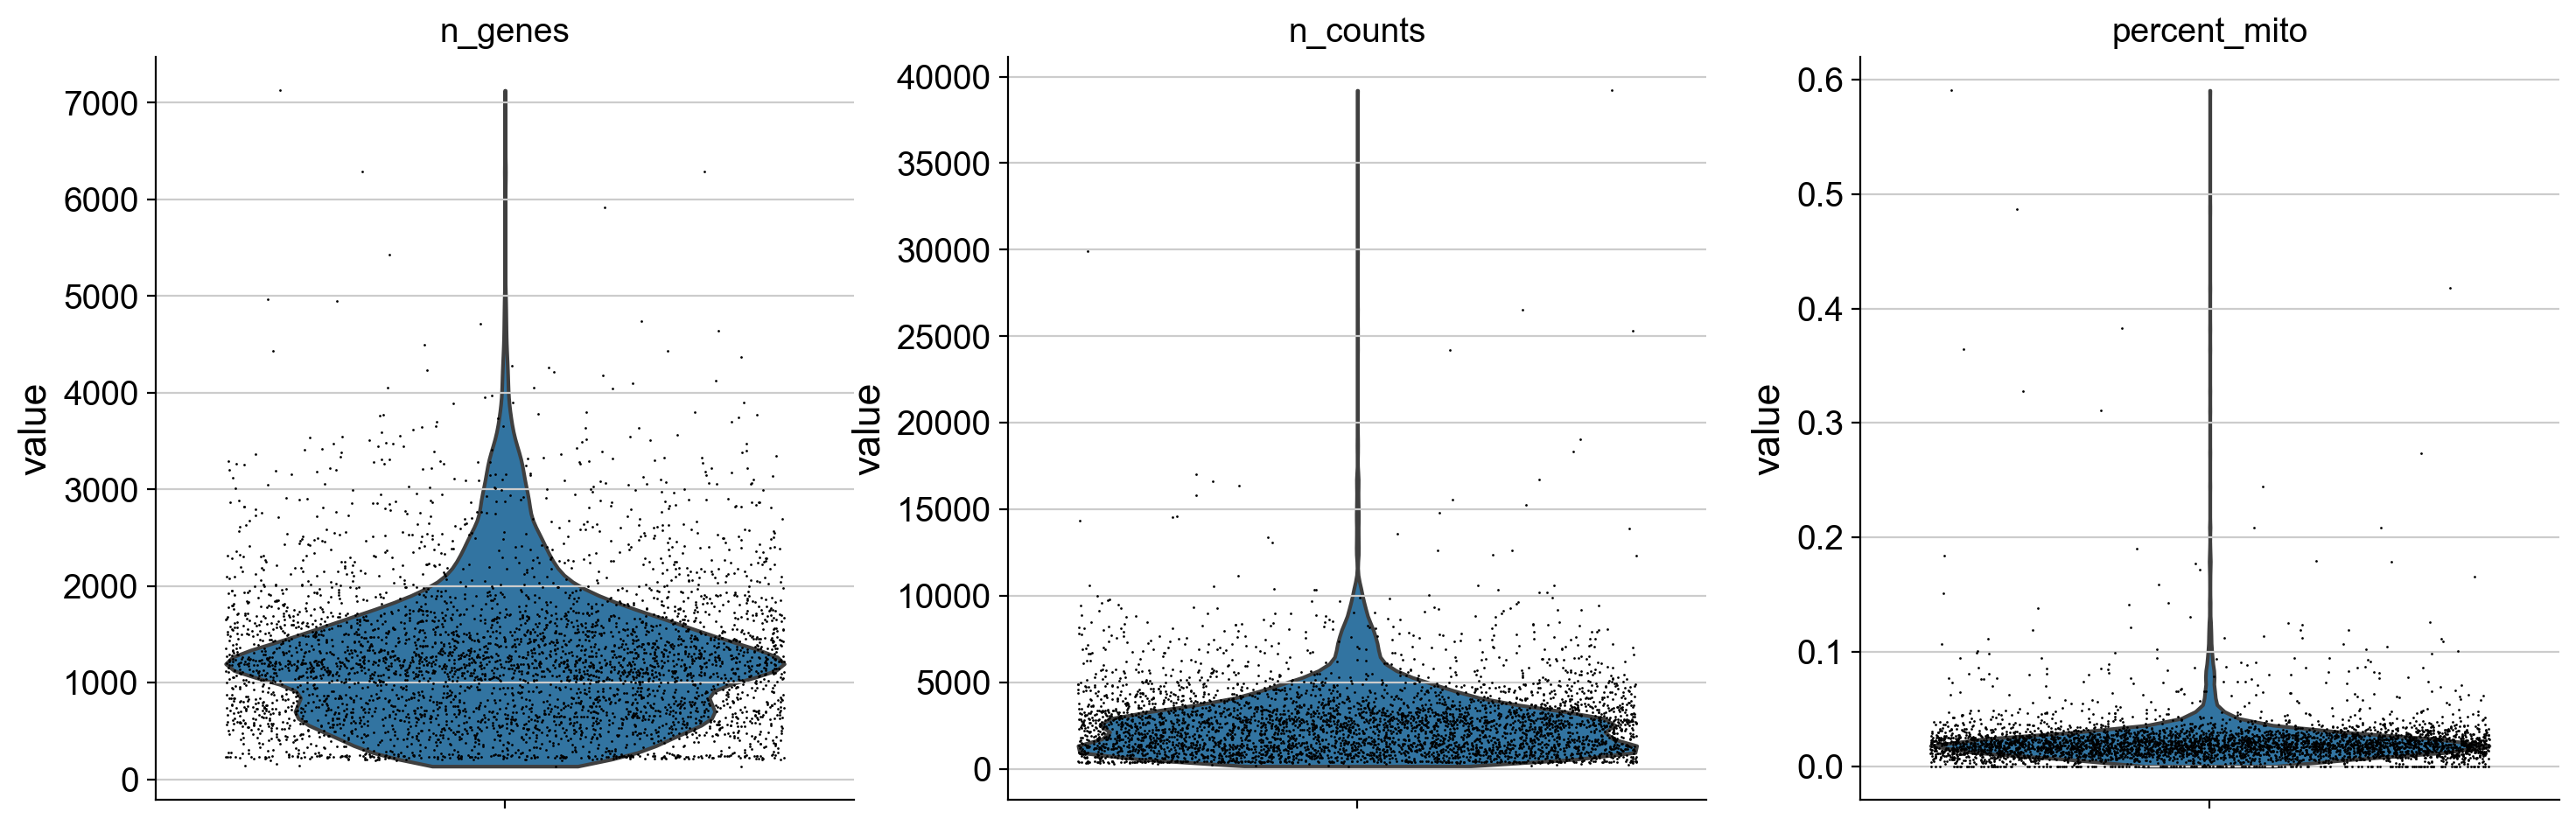

In [30]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
jitter=0.4, multi_panel=True)

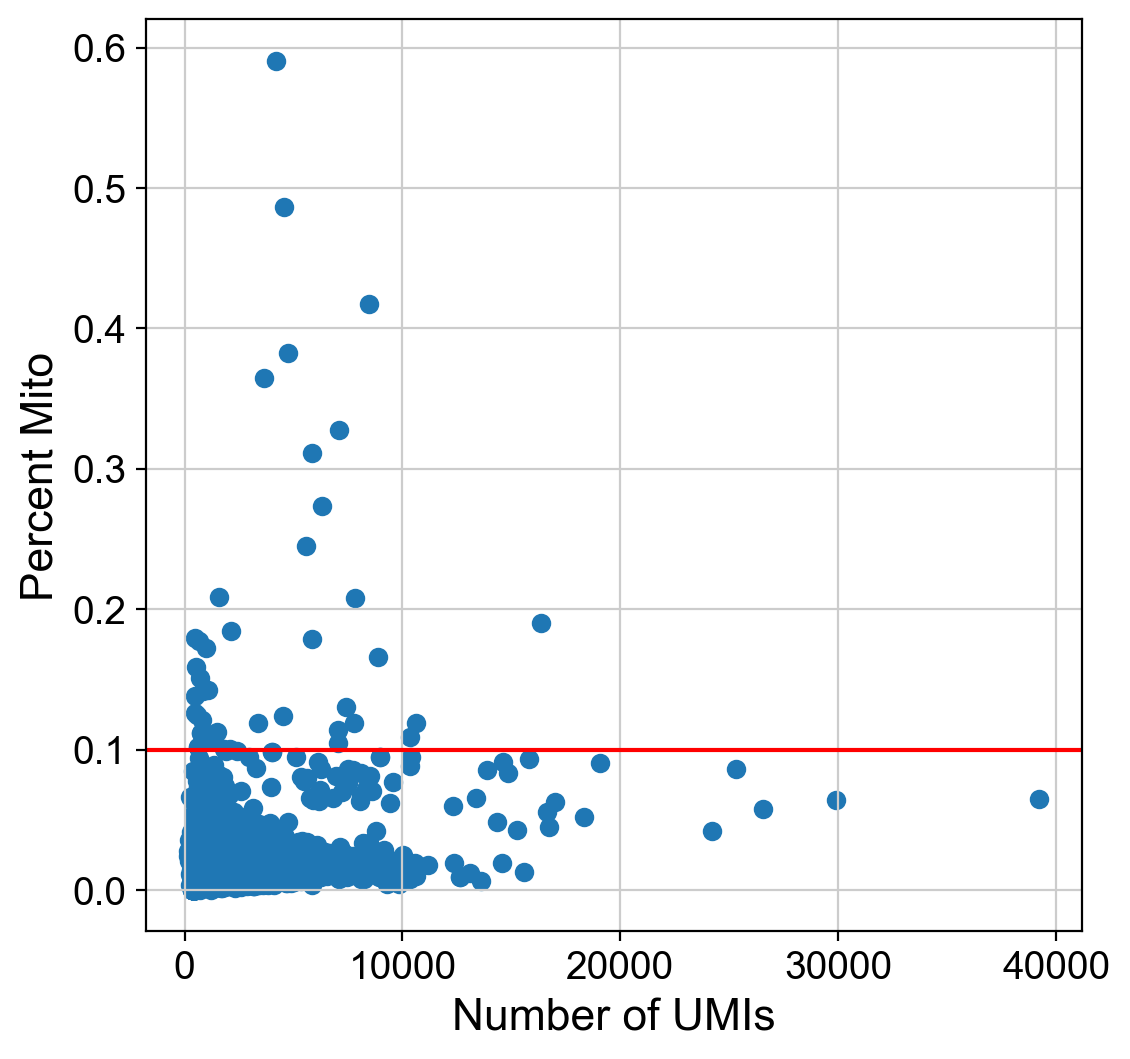

In [31]:
# your code goes here
plt.scatter(adata.obs["n_counts"], adata.obs["percent_mito"])
plt.xlabel('Number of UMIs') # specify the lower cutoff for number of detected genes
plt.ylabel('Percent Mito') # specify the lower cutoff for number of detected genes
plt.axhline(0.1, c='red') # specify a threshold (decimal from 0 to 1) for percentage mitochondrial reads
plt.show()

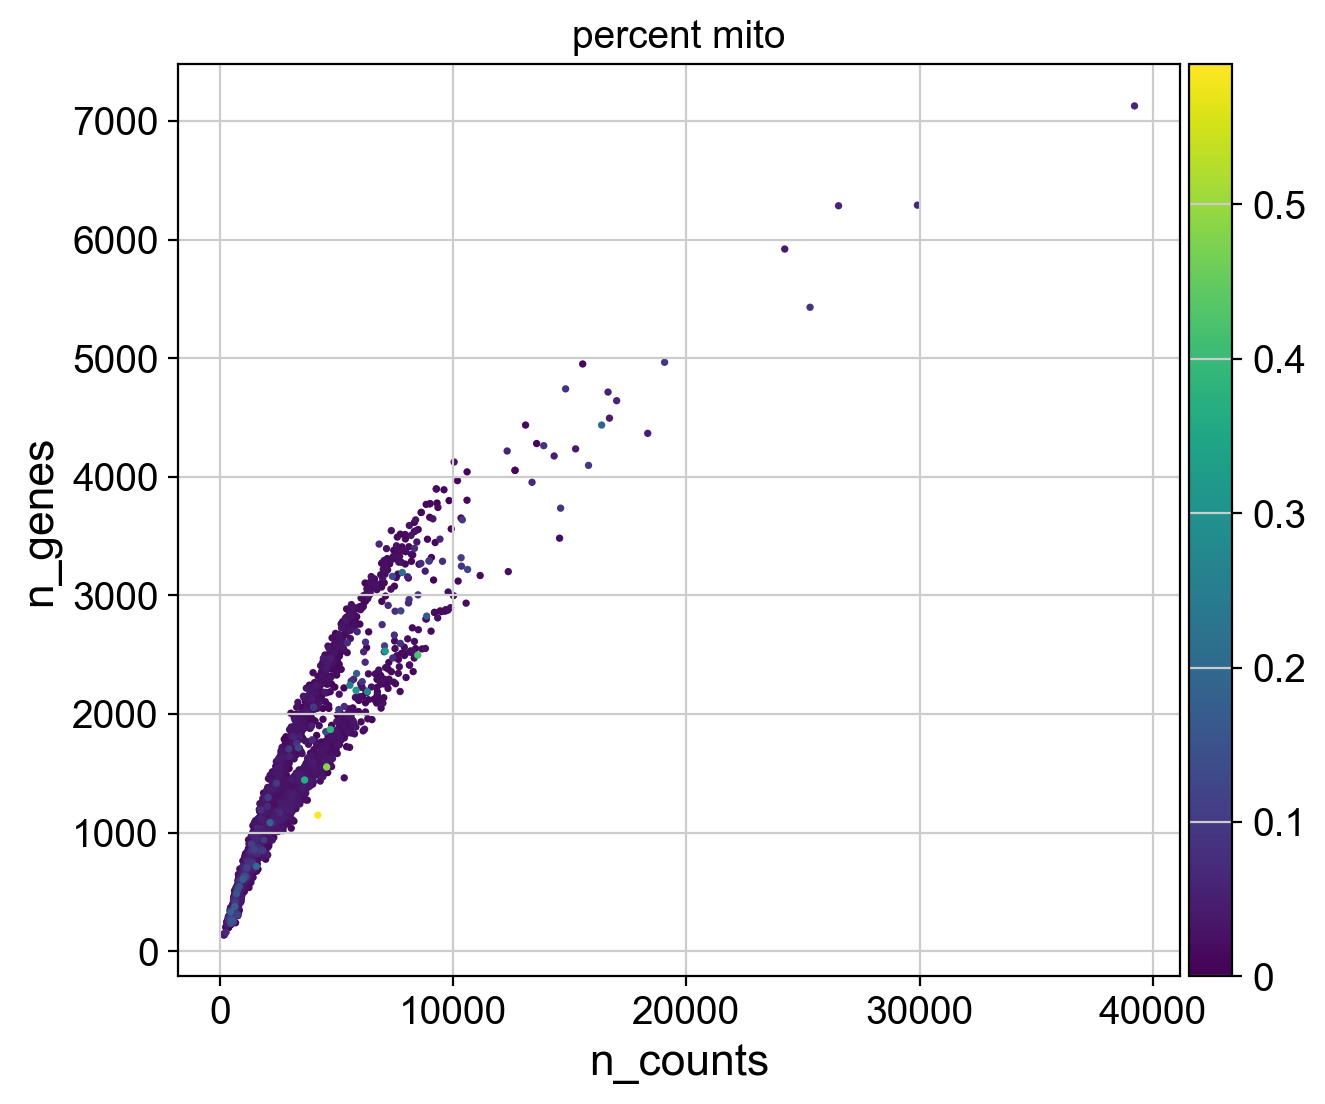

In [32]:
# your code goes here
# Use scanpy to visualize all the three QC metrics: number of UMIs on one axis, number of genes in another and the percent_mito as the color.
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

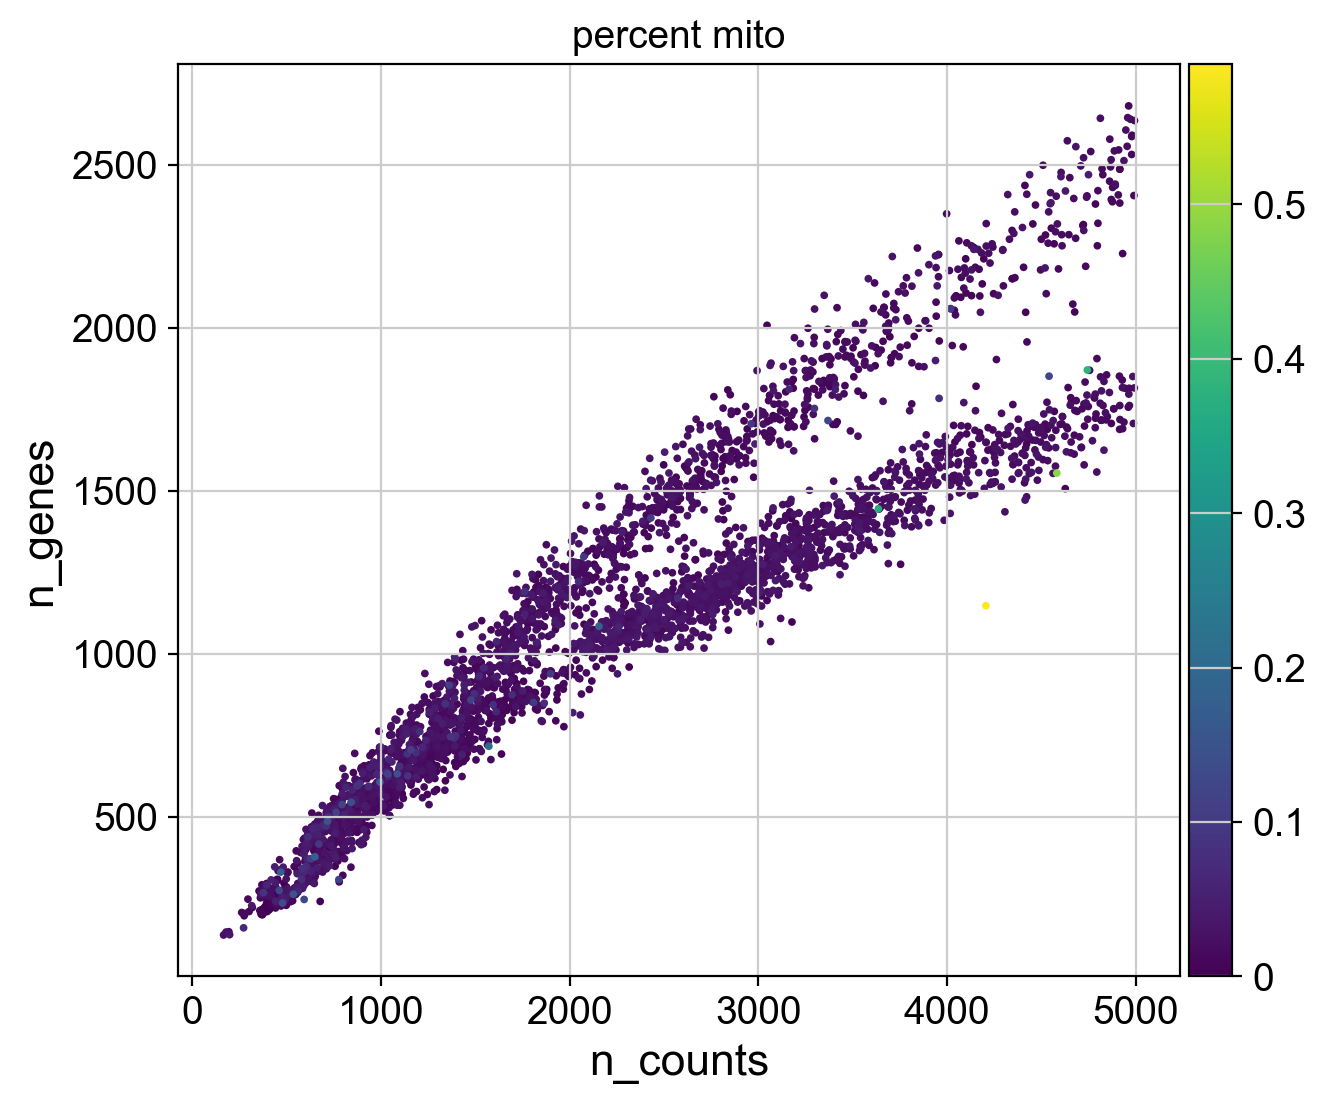

In [33]:
# your code goes here
# You can focus on a specific group of cells to get a more detailed view:
sc.pl.scatter(adata[adata.obs.n_counts<5000], x='n_counts', y='n_genes', color='percent_mito',)




### **Excercise 6:**
Run [scrublet](https://www.sciencedirect.com/science/article/pii/S2405471218304745) to do doublet detection.

The single-cell encapsulation process might generate beads which encapsulate more than one cell. These are termed doublets and are considered an artifact.

[Scrublet](https://www.sciencedirect.com/science/article/pii/S2405471218304745) is a method for doublet detection that will
1. Generate simulated doublets by artificially merging random cells from the dataset
2. Compute the distance between the real cells and these simulated doublets
3. Automatically set a distance threshold that separates real *singlets* from *doublets*, depending on how close they are to the simulated doublets

!['Scrublet summary'](https://ars.els-cdn.com/content/image/1-s2.0-S2405471218304745-fx1.jpg)

In [34]:
# Instantiate the scrublet object
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.1, sim_doublet_ratio=4.0)

In [35]:
# Now run the detection algorithm
doublet_scores, predicted_doublet = scrub.scrub_doublets()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 6.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.8%
Elapsed time: 7.0 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

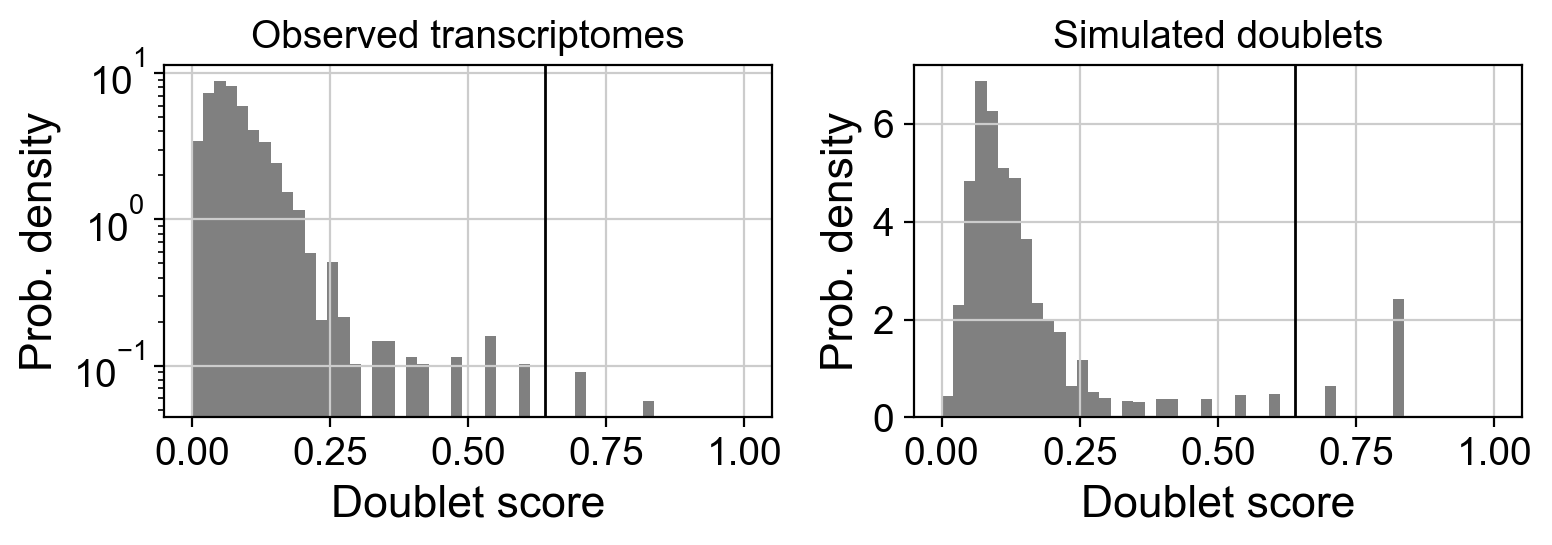

In [36]:
# Visualize the histogram of doublet scores.
# You would expect to see a bimodal distribution with peaks separated by the threshold
scrub.plot_histogram()

In [37]:
# If the doublet score is too high, you can call the call_doublets() function with a new threshold
scrub.call_doublets(threshold=0.25)

Detected doublet rate = 3.4%
Estimated detectable doublet fraction = 14.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 22.8%


array([False, False, False, ...,  True,  True, False])

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

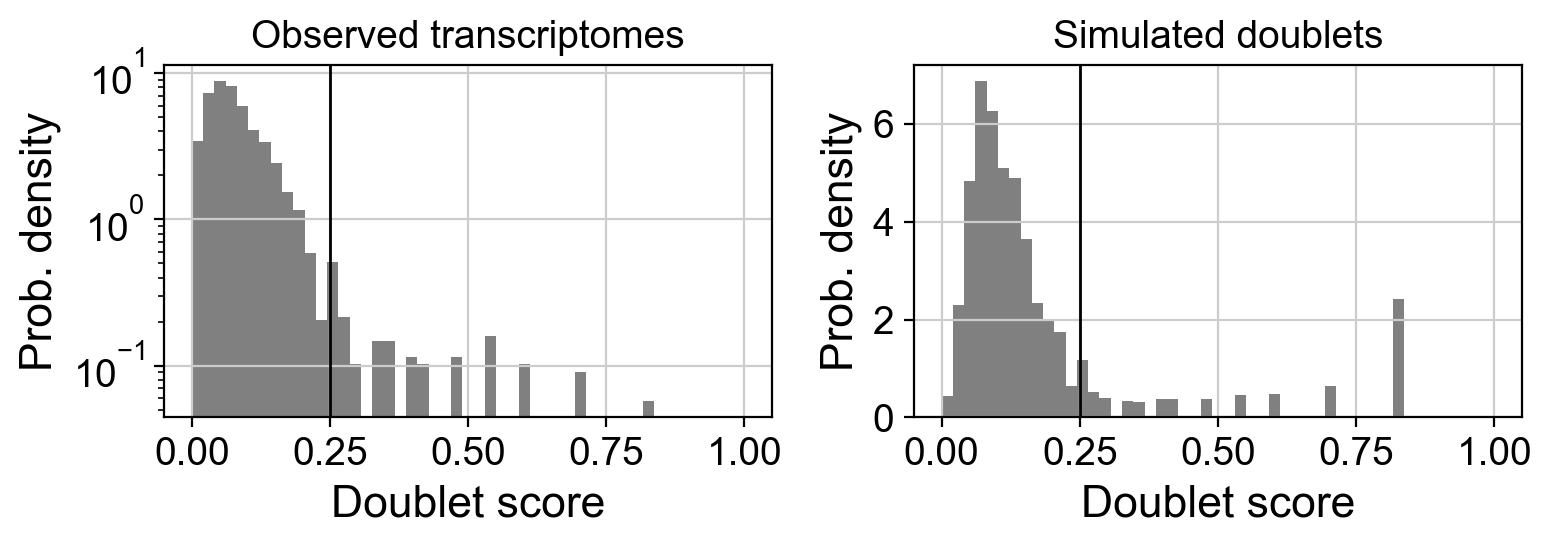

In [38]:
# Check the threshold again
scrub.plot_histogram()

Scrublet returns a list of **doublet scores** (here we called this variable *doublet_scores*) and a **label** (*predicted_doublet* in our code) which classifies each cell as a predicted doublet or a regular cell.
- Add the doublet scores to the .obs of your AnnData object

In [39]:
## Your code here
adata.obs['doublet_score']=doublet_scores
adata.obs['predicted_doublet']=predicted_doublet

Now visualize the doublet scores and the labels together with the QC metrics
- Plot n_counts vs n_genes and use the new doublet detection variables for coloring

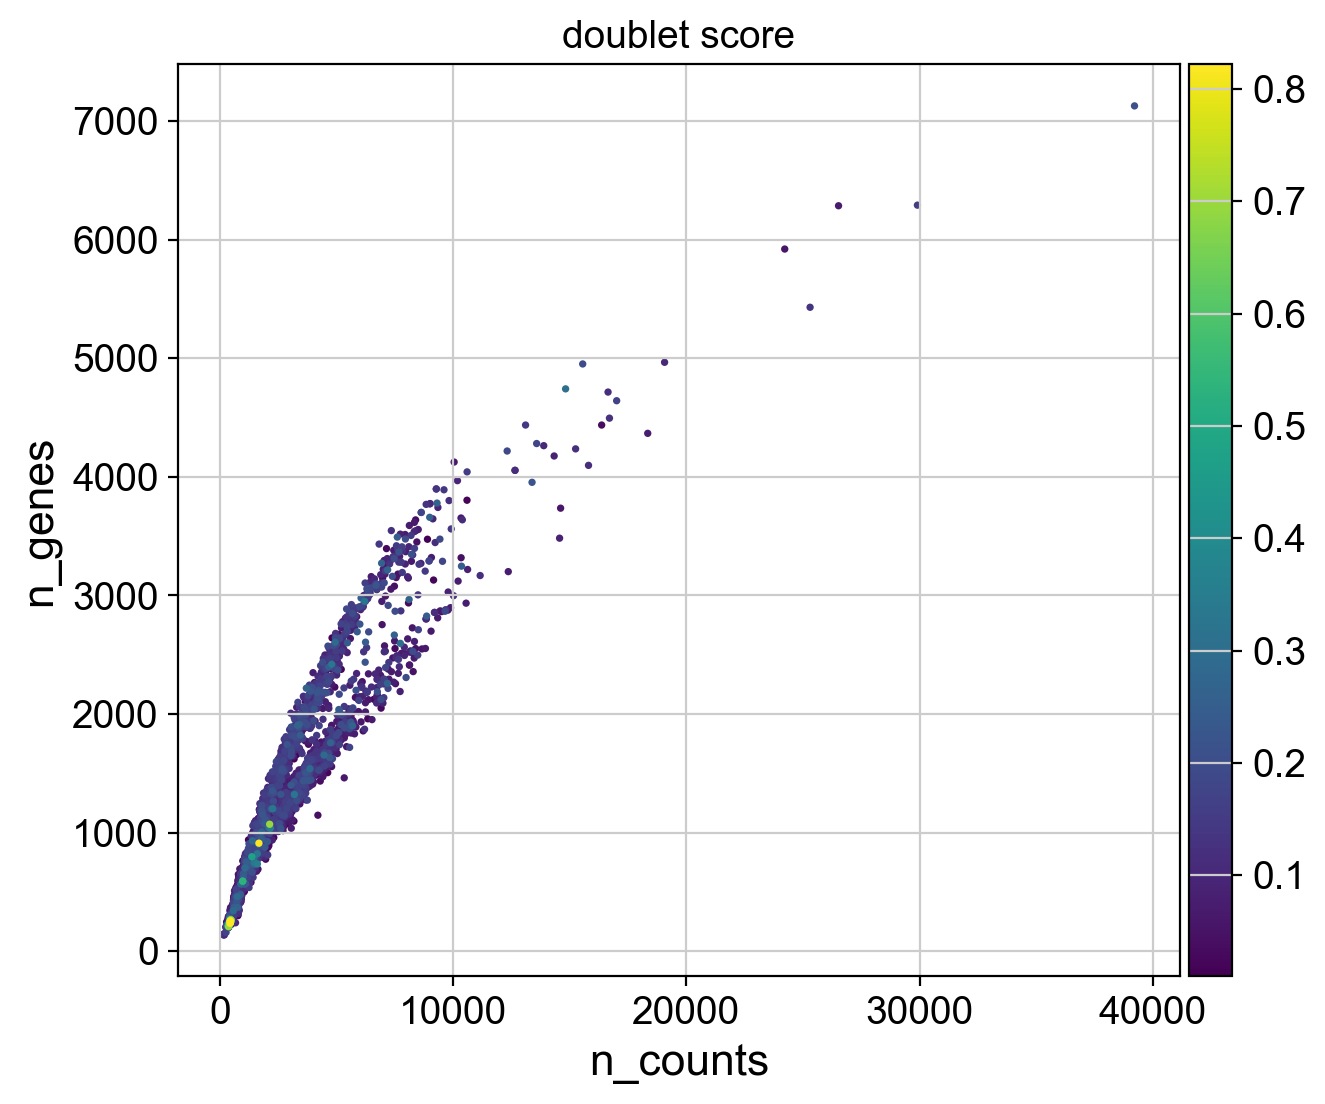

In [40]:
## Your code here
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='doublet_score')

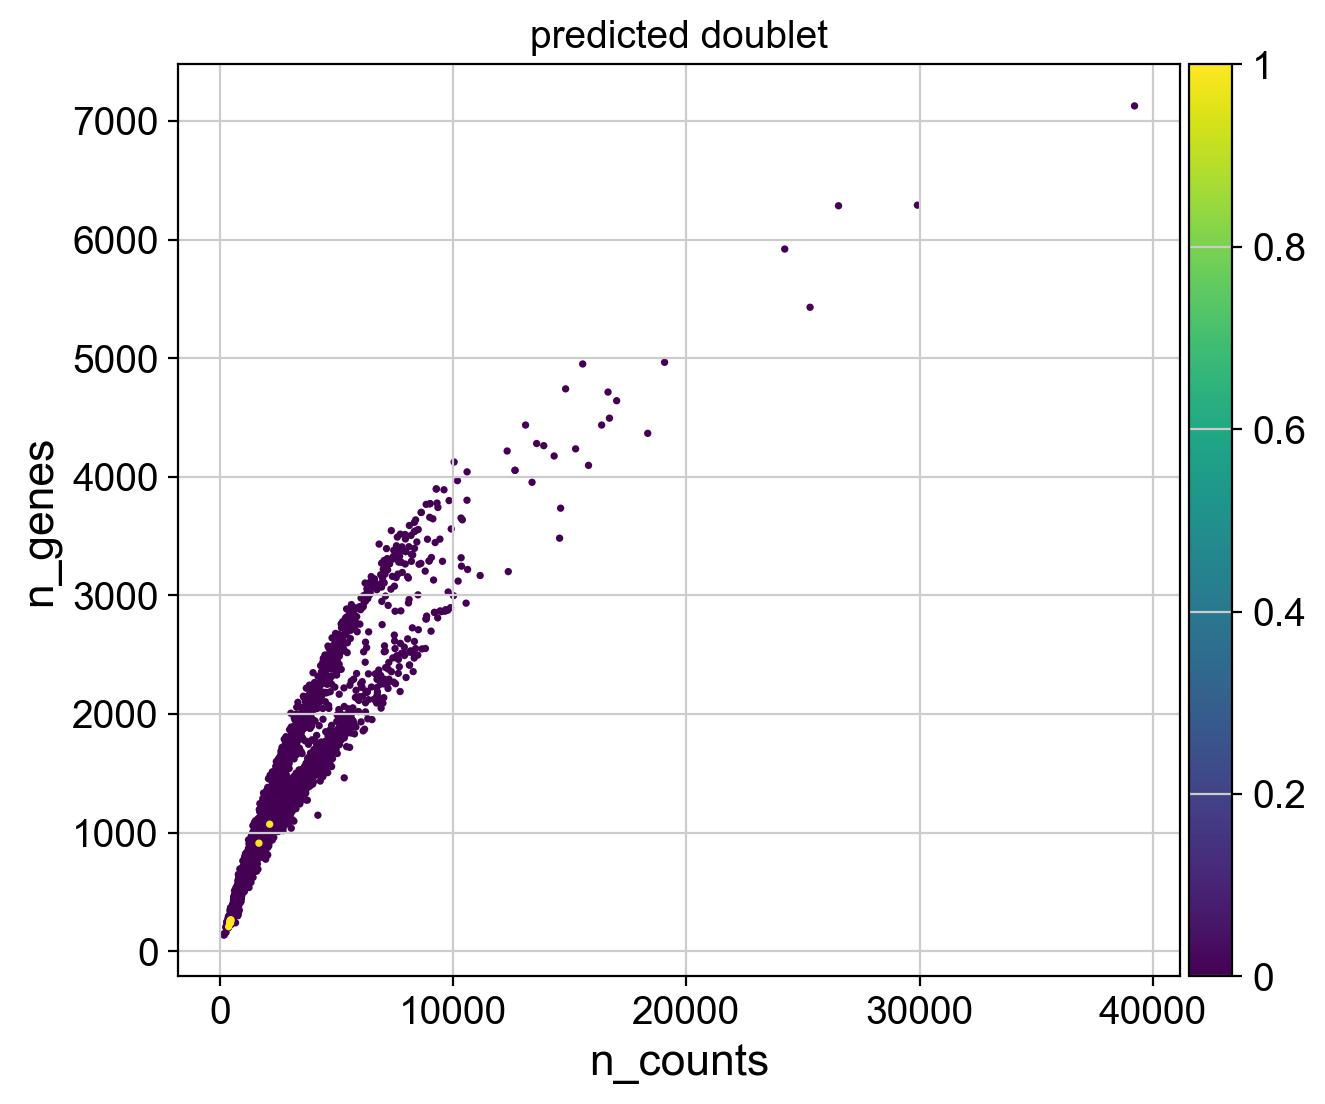

In [41]:
## Your code here
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='predicted_doublet')

### **Exercise 7:**
To get a better feeling for the data, use the same scatterplot to visualize some relevant genes

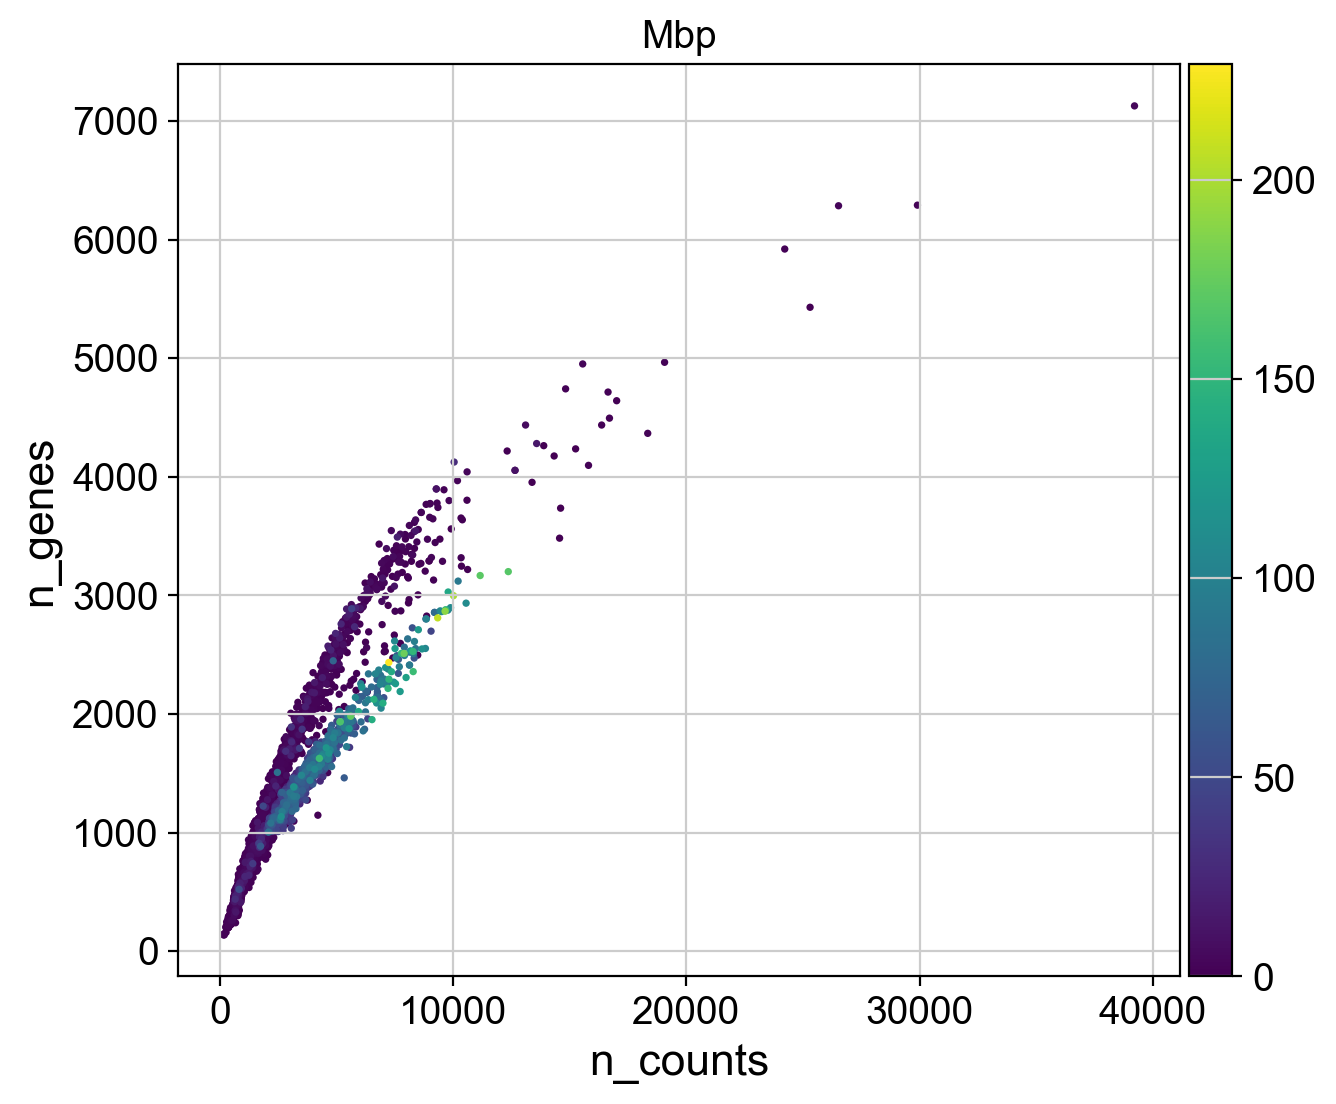

In [42]:
# your code goes here
# Use scanpy to color the distribution of UMIs and genes by some key genes:
# Meg3 is a pan-neuronal marker
# Mbp is a mature oligodendrocyte marker
# Aqp4 marks astrocytes
# Csf1r is a good marker for microglia
# ...
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='Mbp',)


Once you have selected your QC filtering criteria, you need to actually do the filtering!

### **Exercise 8**:
Use the following scanpy function to filter out poor quality cells based on your criteria: sc.pp.filter_cells. How many cells were filtered out?


Hint: you can also filter an AnnData object using indexing approaches, as with numpy arrays and pandas data frames. For instance, the follow command filters genes (columns) on a qc metric for percent mitochondrial reads: adata = adata[adata.obs['percent_mito'] < 0.10, :].copy()

In [43]:
sc.pp.filter_cells(adata, min_counts=1000) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_counts=10000) # apply threshold from above to actually do the filtering

filtered out 784 cells that have less than 1000 counts
filtered out 39 cells that have more than 10000 counts


In [44]:
sc.pp.filter_cells(adata, min_genes=500) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_genes=5000) # apply threshold from above to actually do the filtering

In [45]:
adata = adata[adata.obs['percent_mito'] < 0.1, :].copy() # apply threshold from above to actually do the filtering

In [46]:
adata

AnnData object with n_obs × n_vars = 3441 × 27998
    obs: 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'predicted_doublet'

Remove doublets

In [47]:
adata=adata[~adata.obs.predicted_doublet]

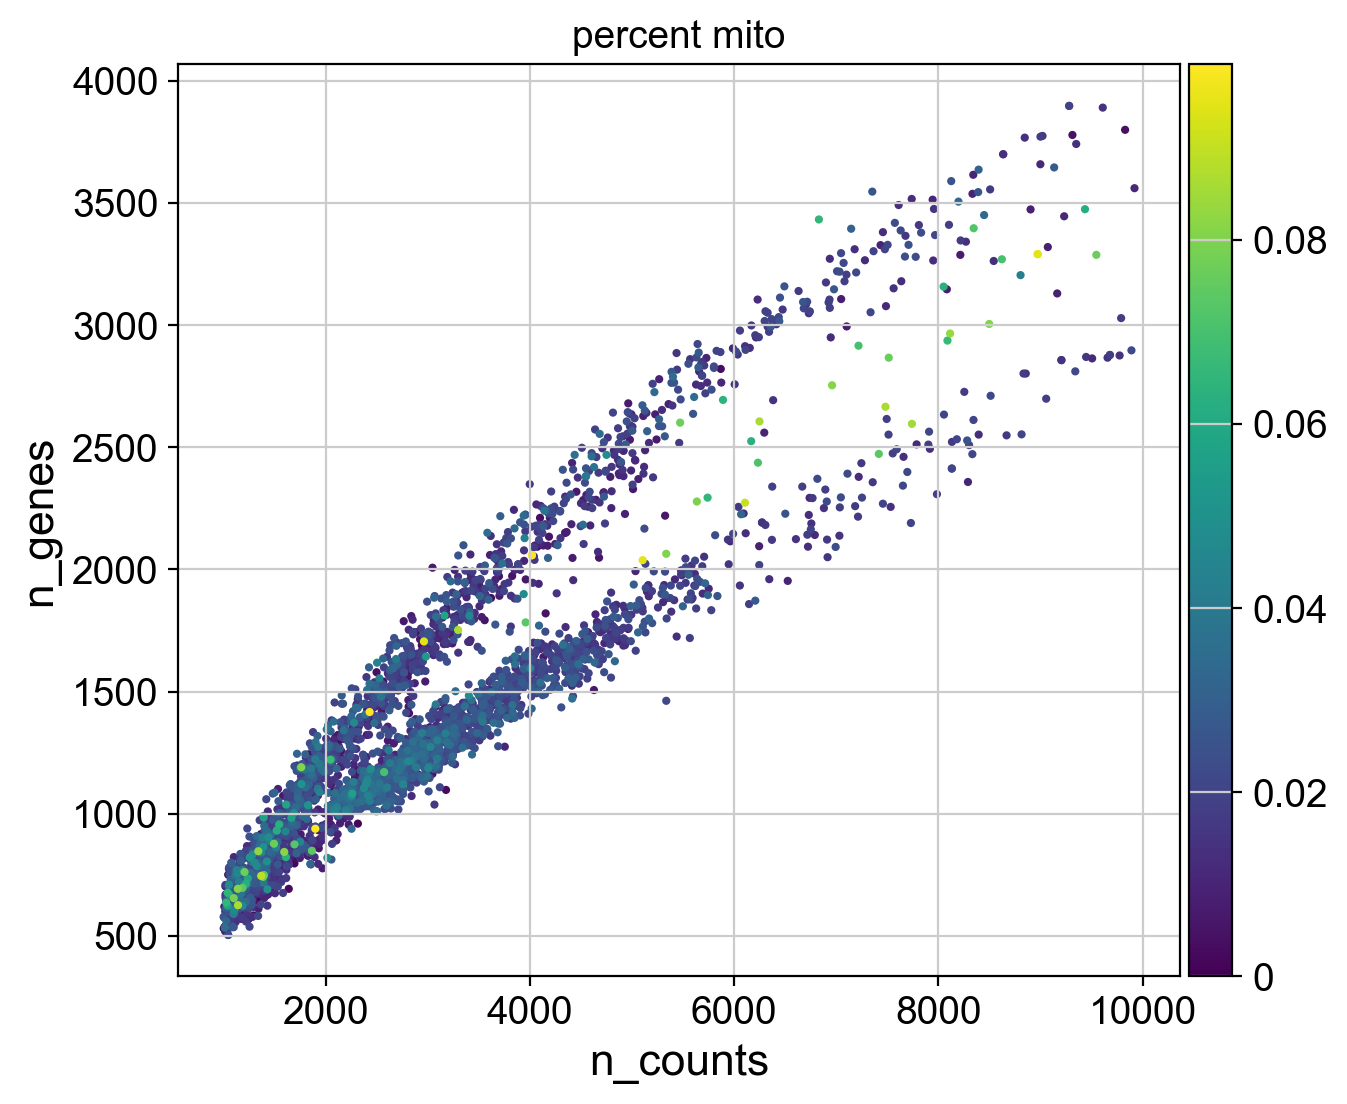

In [48]:
# your code goes here
# Now have a look at the QC plots on your filetered data
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### **Exercise 9**:

Use the function sc.pp.filter_genes to filter out genes expressed in fewer than 1% of your total cells. How many genes are removed?

In [49]:
# your code here
sc.pp.filter_genes(adata, min_cells=int(adata.n_obs*0.01)) # specify min cells equal to 1% of your total cell count

filtered out 16101 genes that are detected in less than 34 cells


/Users/lgarma/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [50]:
adata

AnnData object with n_obs × n_vars = 3439 × 11897
    obs: 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'predicted_doublet'
    var: 'n_cells'

## 2. Normalization

Each count in a count matrix represents the successful capture, reverse transcription and sequencing of a molecule of cellular mRNA. Count depths for identical cells can differ due to the variability inherent in each of these steps. Thus, when gene expression is compared between cells based on count data, any difference may have arisen solely due to sampling effects. Normalization addresses this issue by e.g. scaling count data to obtain correct relative gene expression abundances between cells.

The most commonly used normalization protocol is count depth scaling, also referred to as “counts per million” or CPM normalization. This protocol comes from bulk expression analysis and normalizes count data using a so-called size factor proportional to the count depth per cell. Variations of this method scale the size factors with different factors of 10, or by the median count depth per cell in the dataset. CPM normalization assumes that all cells initially contained the same number of mRNA molecules and that count depth differences arise only due to sampling.

In [51]:
# be sure to save a raw version of your data first!
adata.raw = adata.copy()
adata_raw = adata.copy()

### **Exercise 10**:

Perform normalization on your QC filtered data.

In [52]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
# can you explain what each of the two above lines of code are doing?
# show options of different normalization methods

normalizing counts per cell
    finished (0:00:00)


### **Exercise 11:**
Use scanpy to save the normalized data to a file. Use the write_loom() function to store it as a loompy file (.loom).

In [53]:
# Your code here
# adata.write_loom('Data1_Norm.loom') # Choose a filename to store your data

In [54]:
# Your code here
adata.write_h5ad('Data1_Norm.h5ad') # Choose a filename to store your data

# Summary

In this notebook, we started from a file with raw gene counts.
On this data we performed
- QC
  - We applied scrublet to detect possible doublets
  - We analyzed the number of UMIs and genes detected per cell to detect "low quality cells"
  - We filtered out all the nuclei we considered as technical artifacts (doublets of low QC values) and genes with low expression
- We normalized the data
  - Normalized the counts so that all cells would have 10000 UMIs in total
  - Log-transformed the normalized data
- We stored the normalized data in a new file